In [57]:
import pandas as pd
import numpy as np


from functools import reduce
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from minisom import MiniSom

# 데이터 정리

In [2]:
T_df = pd.read_csv("../data/Total_data_29col.csv", index_col=0)

In [3]:
T_df.corr().loc[T_df.columns, T_df.columns].style.background_gradient()

,time5_9,time9_12,time12_15,time15_18,time18_21,time21_24,역면적,역내엘리베이터개수,역내엘리베이터용량최대,역외엘리베이터개수,역외엘리베이터용량최대,엘리베이터총개수,세대,인구,인구밀도,공실면적,공실수,택배_2308,택배_2307,택배_2306,택배_2305,택배_2304,택배_2303,택배_2302,택배_2301,택배_2212,택배_2211,택배_2210,택배_2209
time5_9,1.000000,0.774815,0.637486,0.751027,0.807770,0.882381,0.135370,-0.143740,-0.090485,0.154921,0.138992,-0.014531,0.111653,0.051595,-0.101175,0.291454,0.333412,0.239252,0.245700,0.258455,0.244432,0.268127,0.262794,0.255120,0.252741,0.237932,0.245326,0.240042,0.246770
time9_12,0.774815,1.000000,0.634294,0.828967,0.853845,0.799784,0.342544,-0.013696,-0.026724,0.294824,0.218870,0.133969,0.067847,0.051858,-0.038236,0.309106,0.326768,0.097652,0.108417,0.122745,0.111885,0.121043,0.117997,0.103750,0.114239,0.102336,0.109770,0.111444,0.113222
time12_15,0.637486,0.634294,1.000000,0.871098,0.817944,0.606434,0.158724,0.252712,0.240275,0.222030,0.222415,0.264488,-0.390456,-0.403926,-0.461081,-0.021272,0.037768,-0.223966,-0.212815,-0.206645,-0.219399,-0.193902,-0.208416,-0.216412,-0.213330,-0.225363,-0.224302,-0.225116,-0.226826
time15_18,0.751027,0.828967,0.871098,1.000000,0.925004,0.616172,0.291481,0.097626,0.036483,0.145472,0.158168,0.131028,-0.144331,-0.157683,-0.250050,0.160528,0.200661,-0.005255,0.005791,0.017737,0.003882,0.022745,0.013745,-0.000981,0.010527,-0.006094,-0.000945,-0.000245,-0.000666
time18_21,0.807770,0.853845,0.817944,0.925004,1.000000,0.760179,0.276909,0.147082,0.029761,0.209174,0.251218,0.192576,-0.113103,-0.125383,-0.259642,0.115715,0.138821,0.091908,0.105388,0.113983,0.102788,0.126436,0.116306,0.107940,0.110717,0.098477,0.100700,0.098481,0.101841
time21_24,0.882381,0.799784,0.606434,0.616172,0.760179,1.000000,0.270654,0.005272,0.044211,0.370937,0.260928,0.182552,0.014684,-0.030397,-0.160048,0.234917,0.265537,0.128413,0.137873,0.148269,0.137830,0.159824,0.154297,0.150173,0.141451,0.134557,0.139389,0.133574,0.141671
역면적,0.135370,0.342544,0.158724,0.291481,0.276909,0.270654,1.000000,-0.018613,-0.064162,0.296451,0.101114,0.131697,-0.084117,-0.073044,-0.120842,0.378948,0.284073,-0.062747,-0.058227,-0.047664,-0.047475,-0.054863,-0.044619,-0.056958,-0.059252,-0.053830,-0.046416,-0.052516,-0.044034
역내엘리베이터개수,-0.143740,-0.013696,0.252712,0.097626,0.147082,0.005272,-0.018613,1.000000,0.748212,0.631336,0.686226,0.927105,-0.599074,-0.567761,-0.519432,-0.001509,0.053954,-0.512652,-0.503606,-0.506330,-0.509445,-0.496937,-0.505035,-0.506917,-0.495871,-0.507788,-0.514770,-0.509528,-0.514007
역내엘리베이터용량최대,-0.090485,-0.026724,0.240275,0.036483,0.029761,0.044211,-0.064162,0.748212,1.000000,0.635425,0.669734,0.772474,-0.213938,-0.191504,-0.133657,0.091496,0.115848,-0.166856,-0.157447,-0.157797,-0.164797,-0.153703,-0.163737,-0.170290,-0.155206,-0.168127,-0.173070,-0.165202,-0.175599
역외엘리베이터개수,0.154921,0.294824,0.222030,0.145472,0.209174,0.370937,0.296451,0.631336,0.635425,1.000000,0.891844,0.875977,-0.230285,-0.226111,-0.198635,0.291751,0.312464,-0.291913,-0.286734,-0.283479,-0.284543,-0.287559,-0.278276,-0.287159,-0.271070,-0.285928,-0.284530,-0.280953,-0.284209


In [8]:
# 혼잡도 데이터는 상관계수가 매우 높아서 max로 통합
Congestion = T_df[['time5_9', 'time9_12', 'time12_15', 'time15_18', 'time18_21','time21_24']]
Congestion = pd.DataFrame(Congestion.max(axis='columns'))
Congestion.columns = ["Congestion"]
Congestion = Congestion.reset_index()

# 역 면적은 상관계수가 높지 않음
Subway_Area = T_df[['역면적']]
Subway_Area.columns = ["Subway_Area"]
Subway_Area = Subway_Area.reset_index()

# 엘리베이터 관련 데이터는 상관계수가 매우 높아서 총 개수만 사용
Elevator = T_df[['엘리베이터총개수']]
Elevator.columns = ["Elevator"]
Elevator = Elevator.reset_index()

# 정주인구 데이터도 상관계수가 높아서 인구만 사용
Population = T_df[['인구']]
Population.columns = ["Population"]
Population = Population.reset_index()

# 공실 데이터도 공실면적만 사용
Lease = T_df[["공실면적"]]
Lease.columns = ["Lease"]
Lease = Lease.reset_index()

# 택배데이터는 1년 평균을 사용
Parcel = T_df[['택배_2308','택배_2307', '택배_2306', '택배_2305', '택배_2304', '택배_2303', '택배_2302',
               '택배_2301', '택배_2212', '택배_2211', '택배_2210', '택배_2209']]
Parcel = pd.DataFrame(Parcel.max(axis='columns'))
Parcel.columns = ["Parcel"]
Parcel = Parcel.reset_index()

In [9]:
T_df = reduce(lambda x,y: pd.merge(x,y, on='역명', how='inner'), [Congestion, Subway_Area, Elevator, Population, Lease, Parcel])
T_df.index = T_df.역명
T_df = T_df.loc[:, ~T_df.columns.isin(["역명"])]

In [12]:
Scaler = MinMaxScaler()
Data_Scale = Scaler.fit_transform(T_df)
DS = pd.DataFrame(Data_Scale)
DS.columns = T_df.columns

In [13]:
[variance_inflation_factor(DS.values, i) for i in range(DS.shape[1])]

[8.314055811500895,
 4.381374953563048,
 3.7659129935463134,
 20.52948251271856,
 1.745008614427845,
 24.770169361409817]

In [14]:
# 다준공선성 제거 (VIF가 10이상)
DS = DS[['Congestion', 'Subway_Area', 'Elevator', 'Population', 'Lease']]
[variance_inflation_factor(DS.values, i) for i in range(DS.shape[1])]

[5.786049955329231,
 4.3751974300993846,
 3.276724293397695,
 2.662080640986178,
 1.5932423745655535]

# 클러스터 갯수 선정
- Elbow : 4개를 최적으로 추천
- Silhouette : 2개기 최적으로 보임

### => 4개, 2개를 각각 실행 후 비교

### Elbow

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, random_state=1234),
                 k=(1, 10))

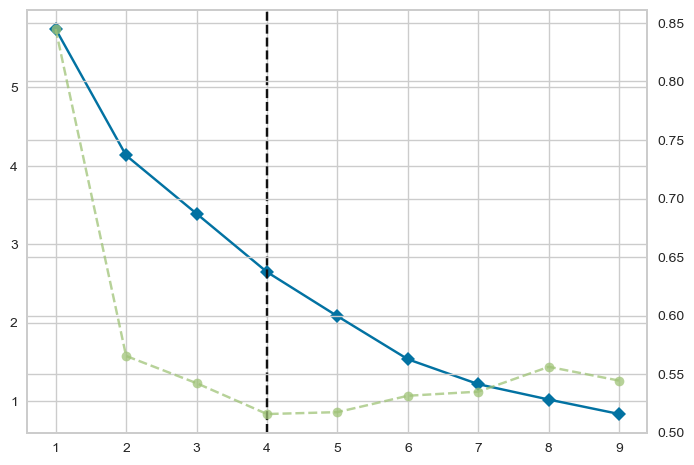

In [15]:
KMeans_Model = KMeans(init='k-means++', random_state = 1234)
visualizer = KElbowVisualizer(KMeans_Model, k=(1,10))
visualizer.fit(DS)

### 2. Silhouette

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


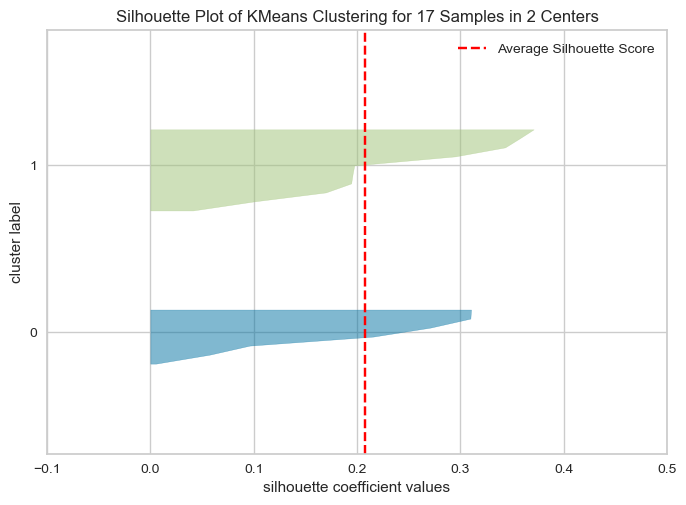

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 17 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
#클러스터링 모델 생성
KMeans_2 = KMeans(n_clusters=2, init='k-means++', random_state = 1234)
#visualizer 생성
visualizer_2 = SilhouetteVisualizer(KMeans_2, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_2.fit(DS)      
visualizer_2.show()

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


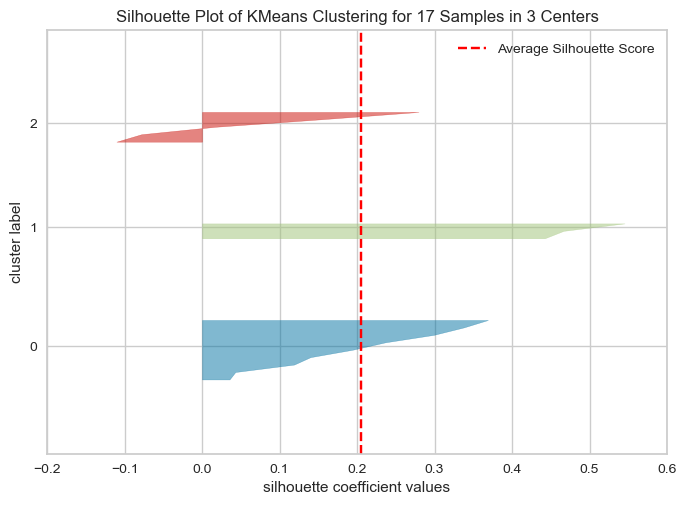

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 17 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
#클러스터링 모델 생성
KMeans_3 = KMeans(n_clusters=3, init='k-means++', random_state = 1234)
#visualizer 생성
visualizer_3 = SilhouetteVisualizer(KMeans_3, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_3.fit(DS)      
visualizer_3.show()

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


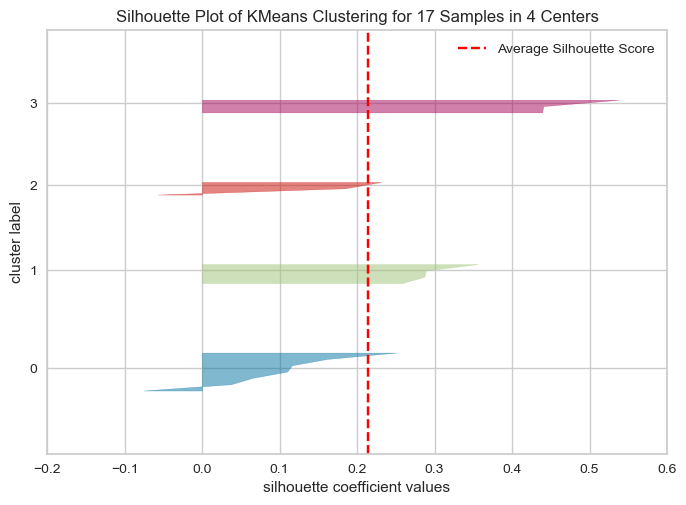

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 17 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
#클러스터링 모델 생성
KMeans_4 = KMeans(n_clusters=4,init='k-means++', random_state = 1234)
#visualizer 생성
visualizer_4 = SilhouetteVisualizer(KMeans_4, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_4.fit(DS)      
visualizer_4.show()

# 모델링

### 1. K = 2

### - K-means

In [19]:
k = 2
KMeans_Model = KMeans(n_clusters = k,init='k-means++', random_state = 1234)

# 정규화된 데이터에 학습
KMeans_Model.fit(DS)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
T_KMeans = T_df.copy()
T_KMeans['cluster'] = KMeans_Model.fit_predict(DS)

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

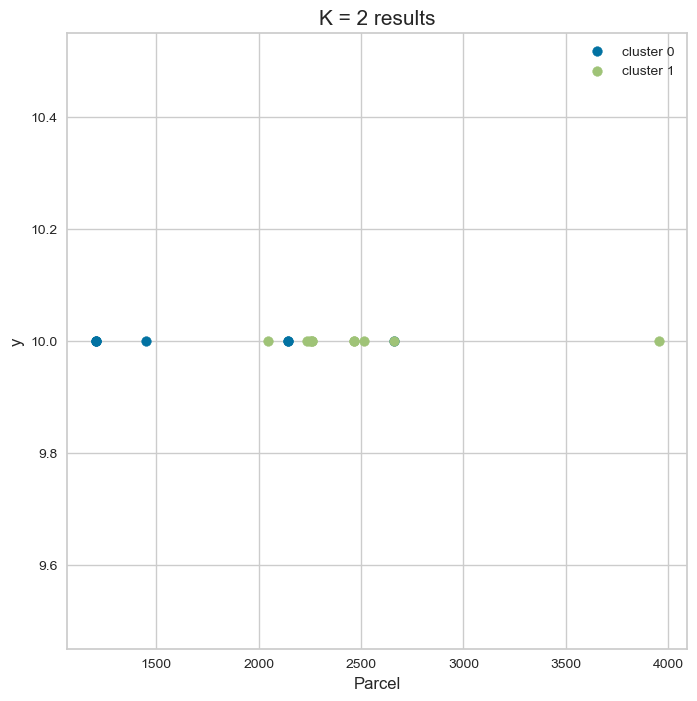

In [20]:
plt.figure(figsize = (8, 8))

c = 5
for i in range(k):
    plt.scatter(T_KMeans.loc[T_KMeans['cluster'] == i, T_KMeans.columns[c]], [10]*len(T_KMeans.loc[T_KMeans['cluster'] == i, T_KMeans.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(T_KMeans.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

- cluster 0 : 혼잡도 - 중간쯤 분포, 엘리베이터 - 8 이하, 인구 - 적은 편, 택배 - 적은 편
- cluster 1 : 혼잡도 - 고루 분포, 엘리베이터 - 10 이상, 인구 - 많은 편, 택배 - 많은 편

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


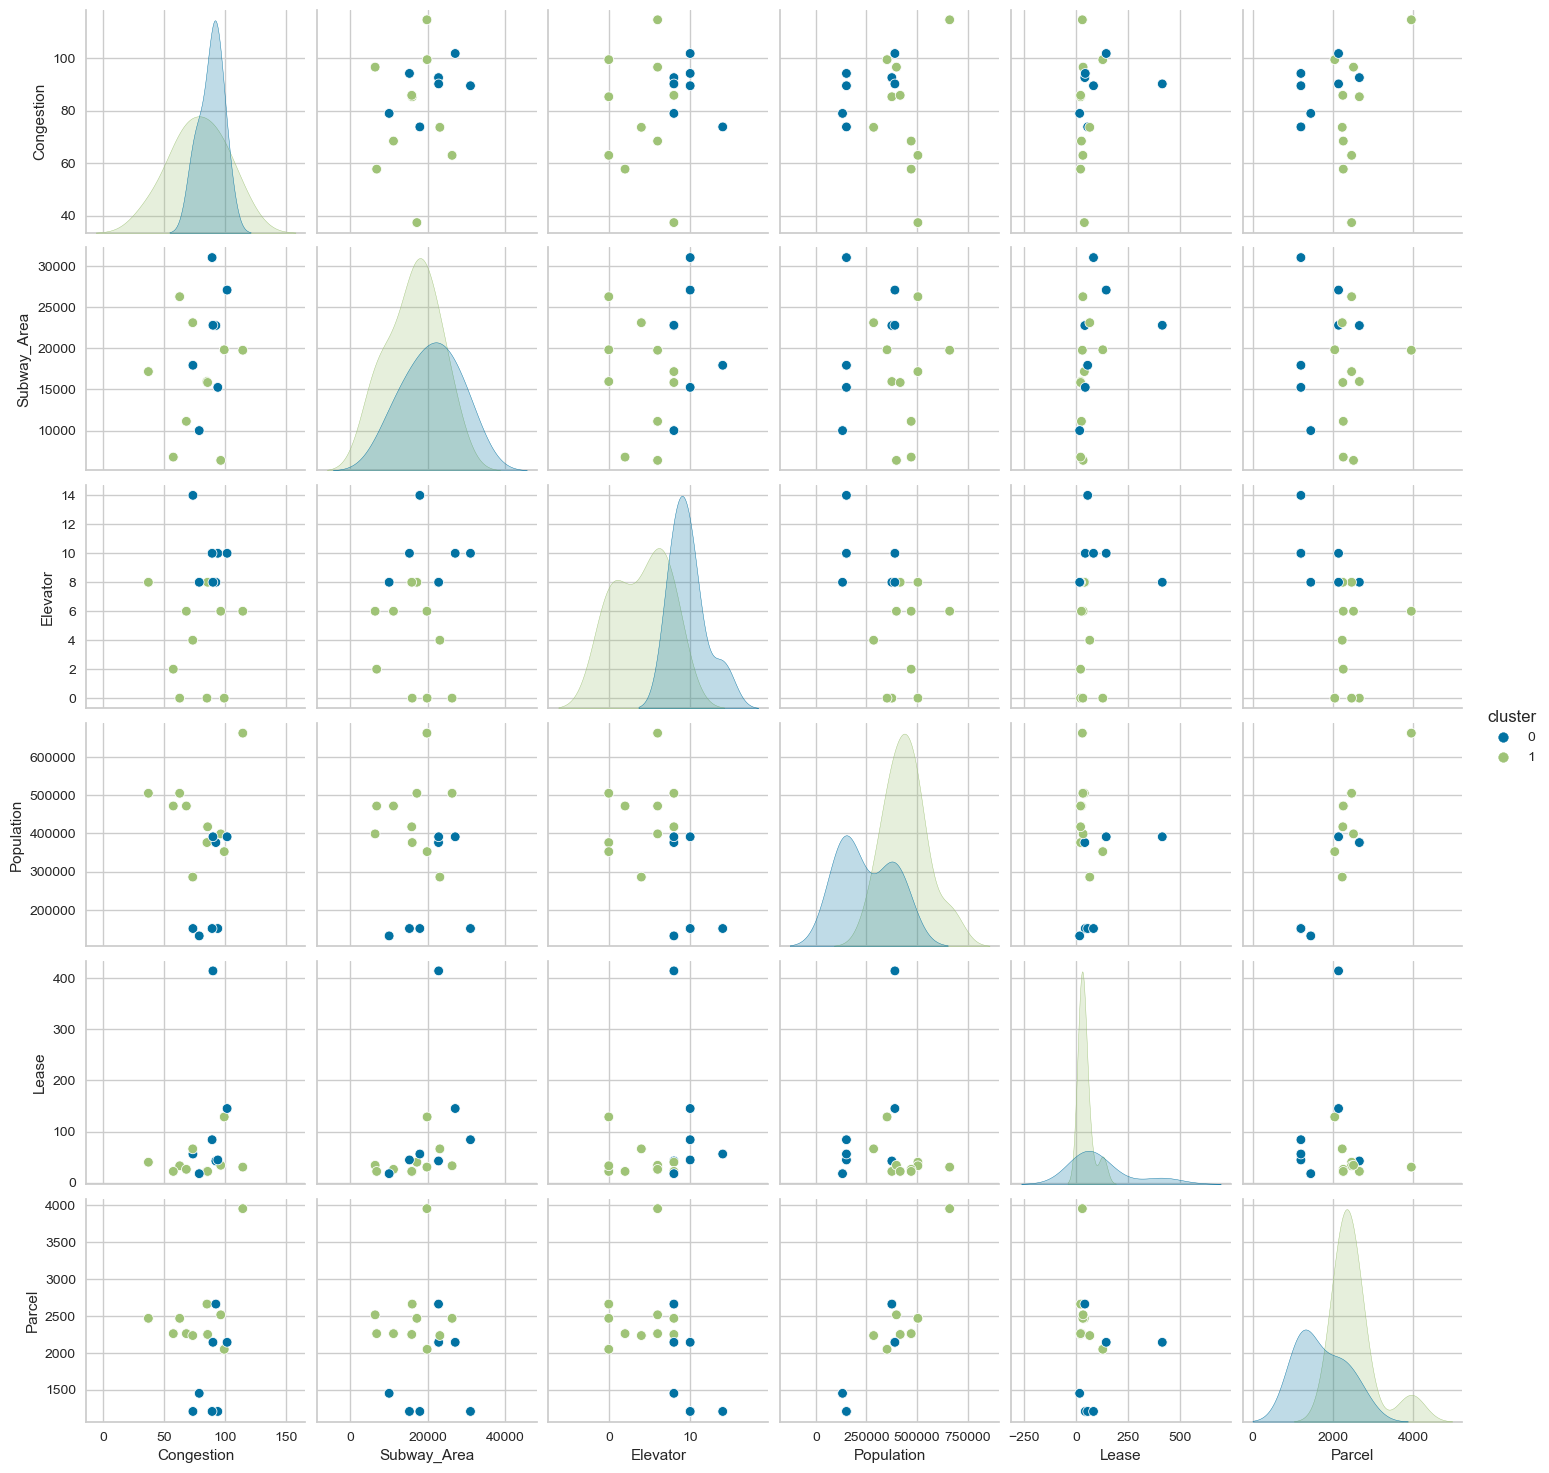

In [22]:
sns.pairplot(T_KMeans, hue="cluster")
plt.show()

### GMM

In [23]:
GMM = GaussianMixture(n_components=2, random_state = 1234)
GMM.fit(DS)
cluster = GMM.predict(DS)
Total_GMM = T_df.copy()
Total_GMM['cluster'] = cluster

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


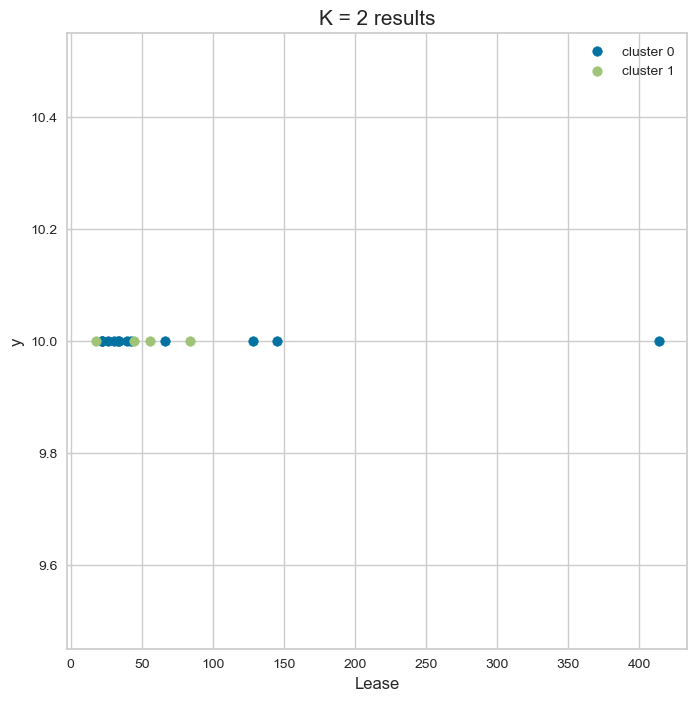

In [24]:
plt.figure(figsize = (8, 8))

c = 4
for i in range(k):
    plt.scatter(Total_GMM.loc[Total_GMM['cluster'] == i, Total_GMM.columns[c]], [10]*len(Total_GMM.loc[Total_GMM['cluster'] == i, Total_GMM.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_GMM.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

- cluster 0 : 혼잡도 - 고루 분포, 엘리베이터 -  6 이하, 인구 - 많은 편, 택배 - 많은 편
- cluster 1 : 혼잡도 - 중간쯤 분포, 엘리베이터 - 8 이상, 인구 - 적은 편, 택배 - 적은 편

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


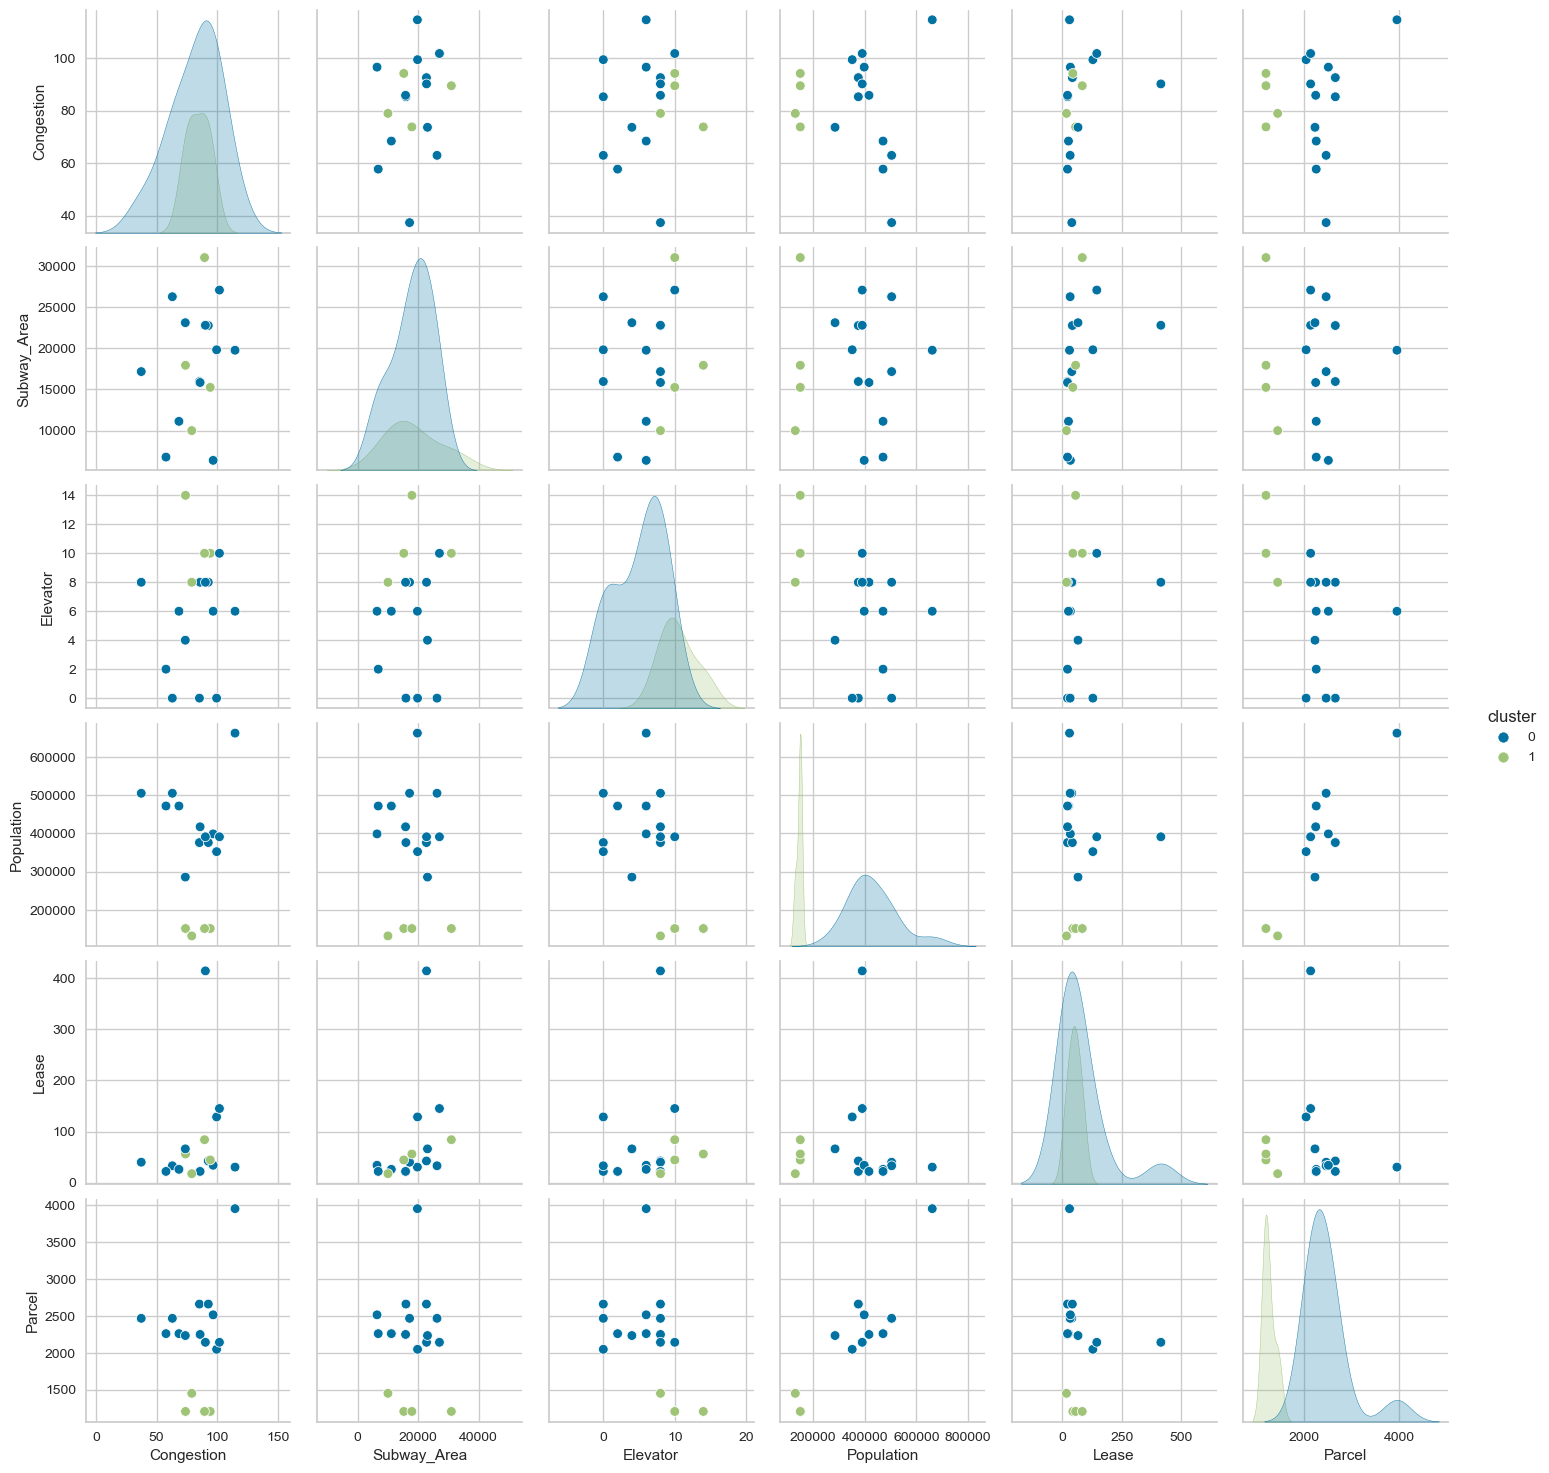

In [26]:
sns.pairplot(Total_GMM, hue="cluster")
plt.show()

### DBSCAN

In [27]:
DBSCAN_Model = DBSCAN(eps=0.5,min_samples=2)
cluster = DBSCAN_Model.fit_predict(DS)
Total_DBSCAN = T_df.copy()
Total_DBSCAN['cluster'] = cluster

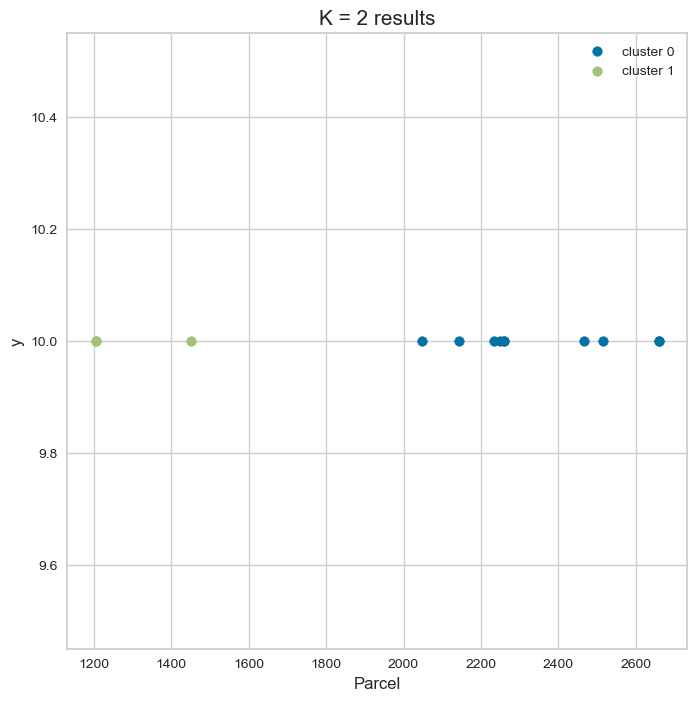

In [28]:
plt.figure(figsize = (8, 8))

c = 5
for i in range(k):
    plt.scatter(Total_DBSCAN.loc[Total_DBSCAN['cluster'] == i, Total_DBSCAN.columns[c]], [10]*len(Total_DBSCAN.loc[Total_DBSCAN['cluster'] == i, Total_DBSCAN.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_DBSCAN.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

- cluster 0 : 혼잡도 - 고루 분포, 역 면적 - 고루 분포, 엘리베이터 -  6 이하, 인구 - 많은 편, 택배 - 많은 편
- cluster 1 : 혼잡도 - 중간쯤 분포, 역 면적 - 중간쯤 분포, 엘리베이터 - 8 이상, 인구 - 적은 편, 택배 - 적은 편

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


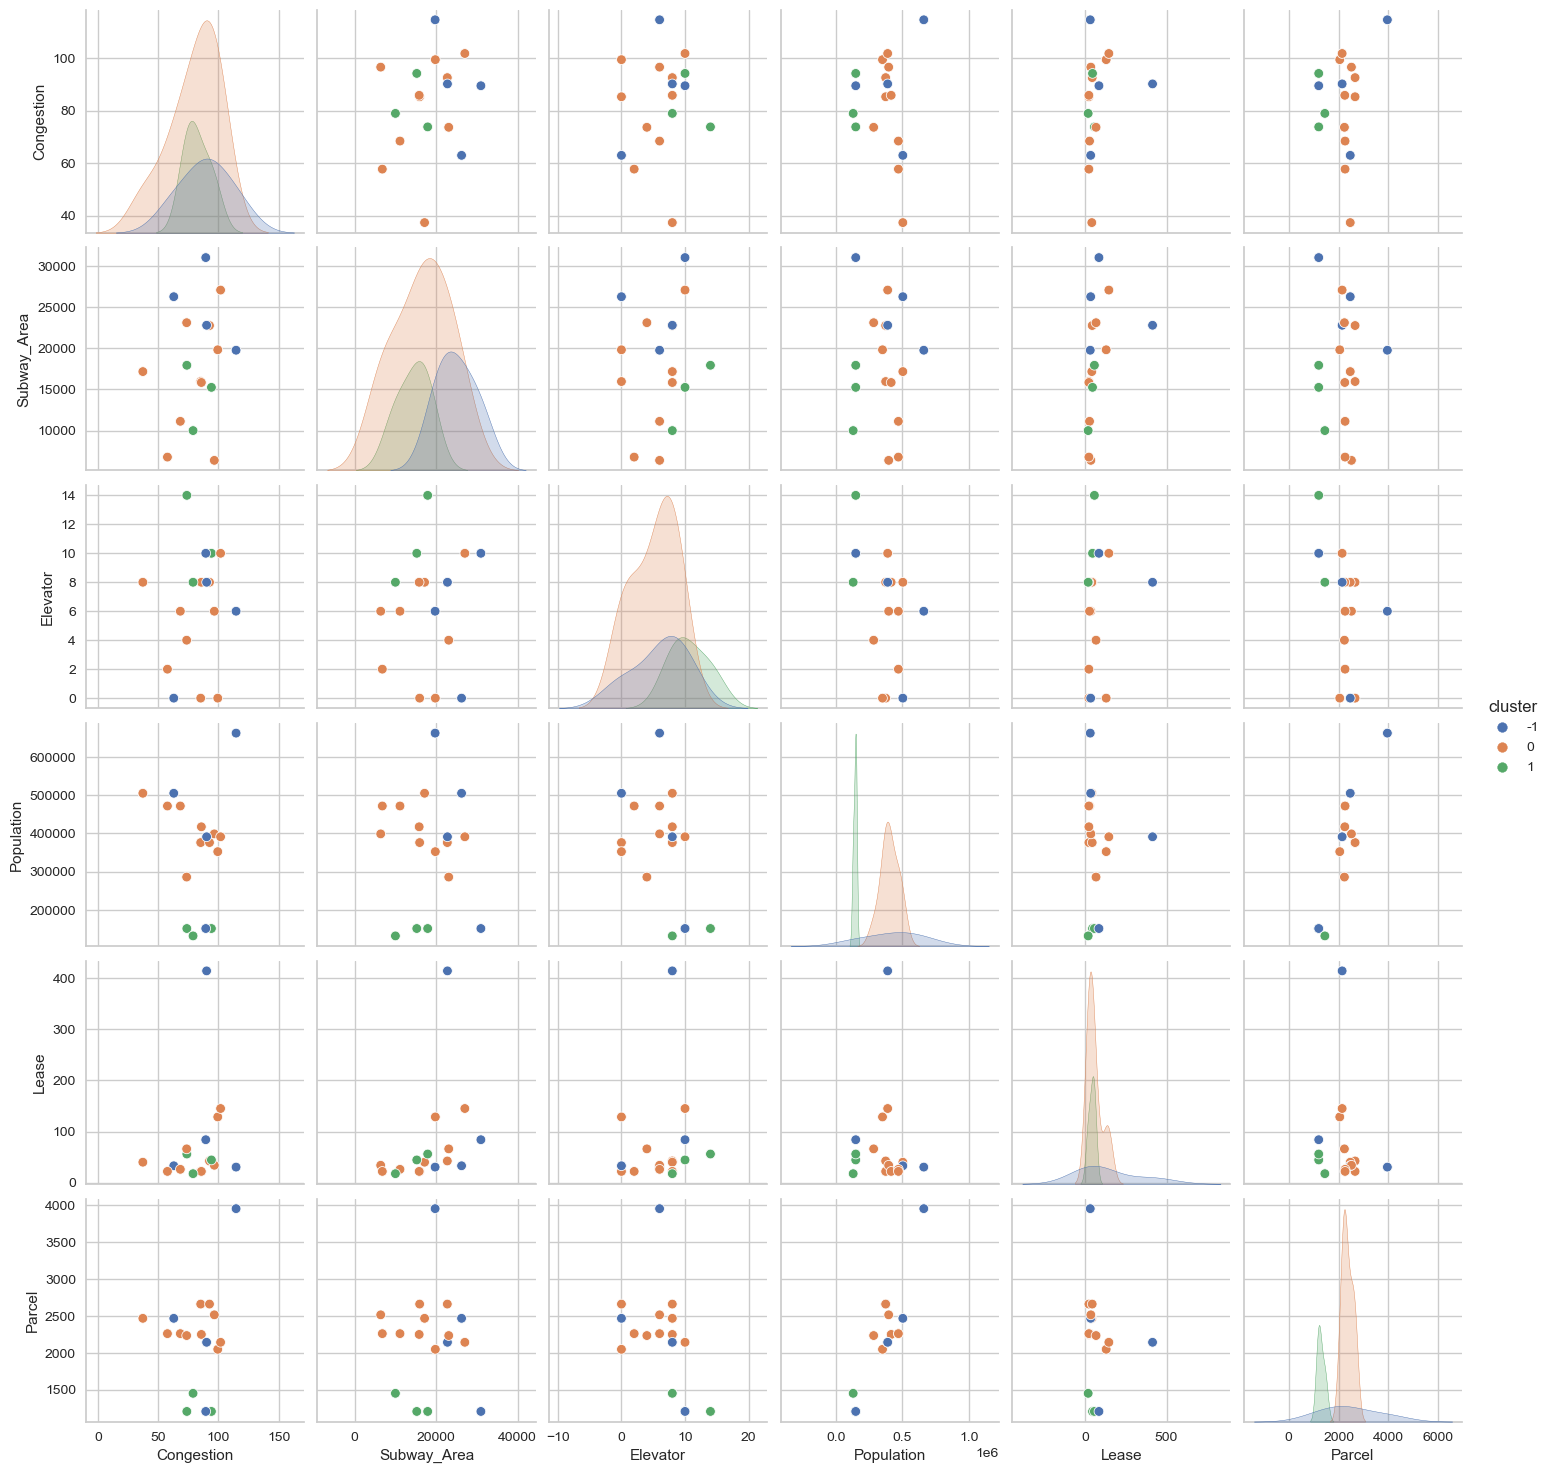

In [58]:
palette = sns.color_palette("deep", 3)
sns.pairplot(Total_DBSCAN, hue="cluster", palette = palette)
plt.show()

### SOM

In [31]:
SOM = MiniSom(x = 2, y = 1, input_len = 5)
SOM.random_weights_init(DS.values)
SOM.train(DS.values, 100)

C:\Users\Ryzen\anaconda3\Lib\site-packages\minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


In [32]:
Win = np.array([SOM.winner(x) for x in DS.values]).T
Total_SOM = T_df.copy()
Total_SOM['cluster'] = np.ravel_multi_index(Win,(2,2))
Total_SOM

,Congestion,Subway_Area,Elevator,Population,Lease,Parcel,cluster
역명,,,,,,,
가락시장역,114.65,19754.13,6.0,661515,30.44,3955.503922,2
공덕역,85.30,15953.14,0.0,375639,22.00,2660.887574,2
합정역,92.60,22750.80,8.0,375639,42.41,2660.887574,0
군자역,99.45,19806.00,0.0,351959,128.50,2047.261811,2
노원역,37.30,17160.94,8.0,504423,40.00,2467.522682,2
태릉입구역,62.95,26250.28,0.0,504423,33.00,2467.522682,2
당산역,96.60,6385.00,6.0,398290,34.00,2514.923529,2
대림역,85.85,15835.53,8.0,416815,22.00,2248.816568,2
동대문역,94.20,15245.30,10.0,151127,44.40,1204.092885,0


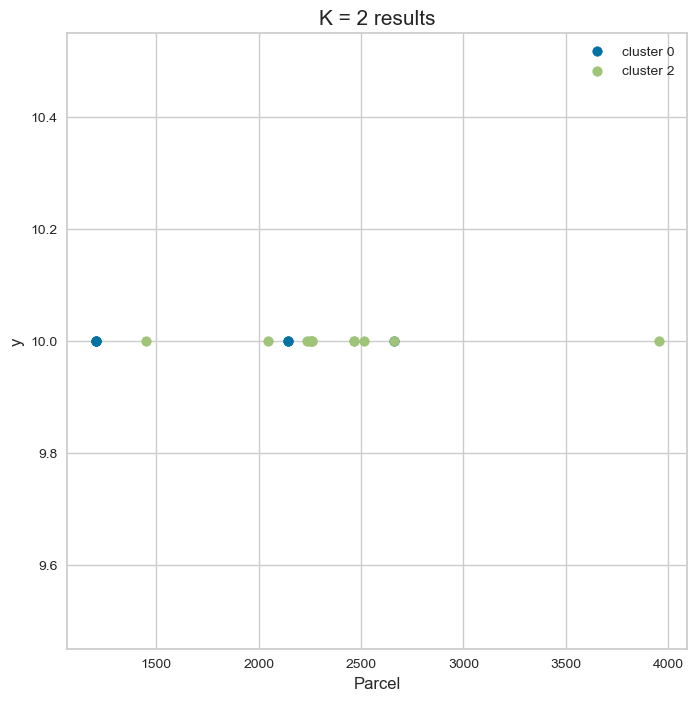

In [33]:
plt.figure(figsize = (8, 8))

c = 5
for i in list(set(Total_SOM.cluster)):
    plt.scatter(Total_SOM.loc[Total_SOM['cluster'] == i, Total_SOM.columns[c]], [10]*len(Total_SOM.loc[Total_SOM['cluster'] == i, Total_SOM.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_SOM.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

- cluster 0 : 혼잡도 - 고루 분포,  엘리베이터 -  6 이하, 인구 - 고루 분포, 공실 - 적은 편
- cluster 1 : 혼잡도 - 중간쯤 분포,  엘리베이터 - 8 이상, 인구 - 적음~중간, 공실 - 고른 편

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


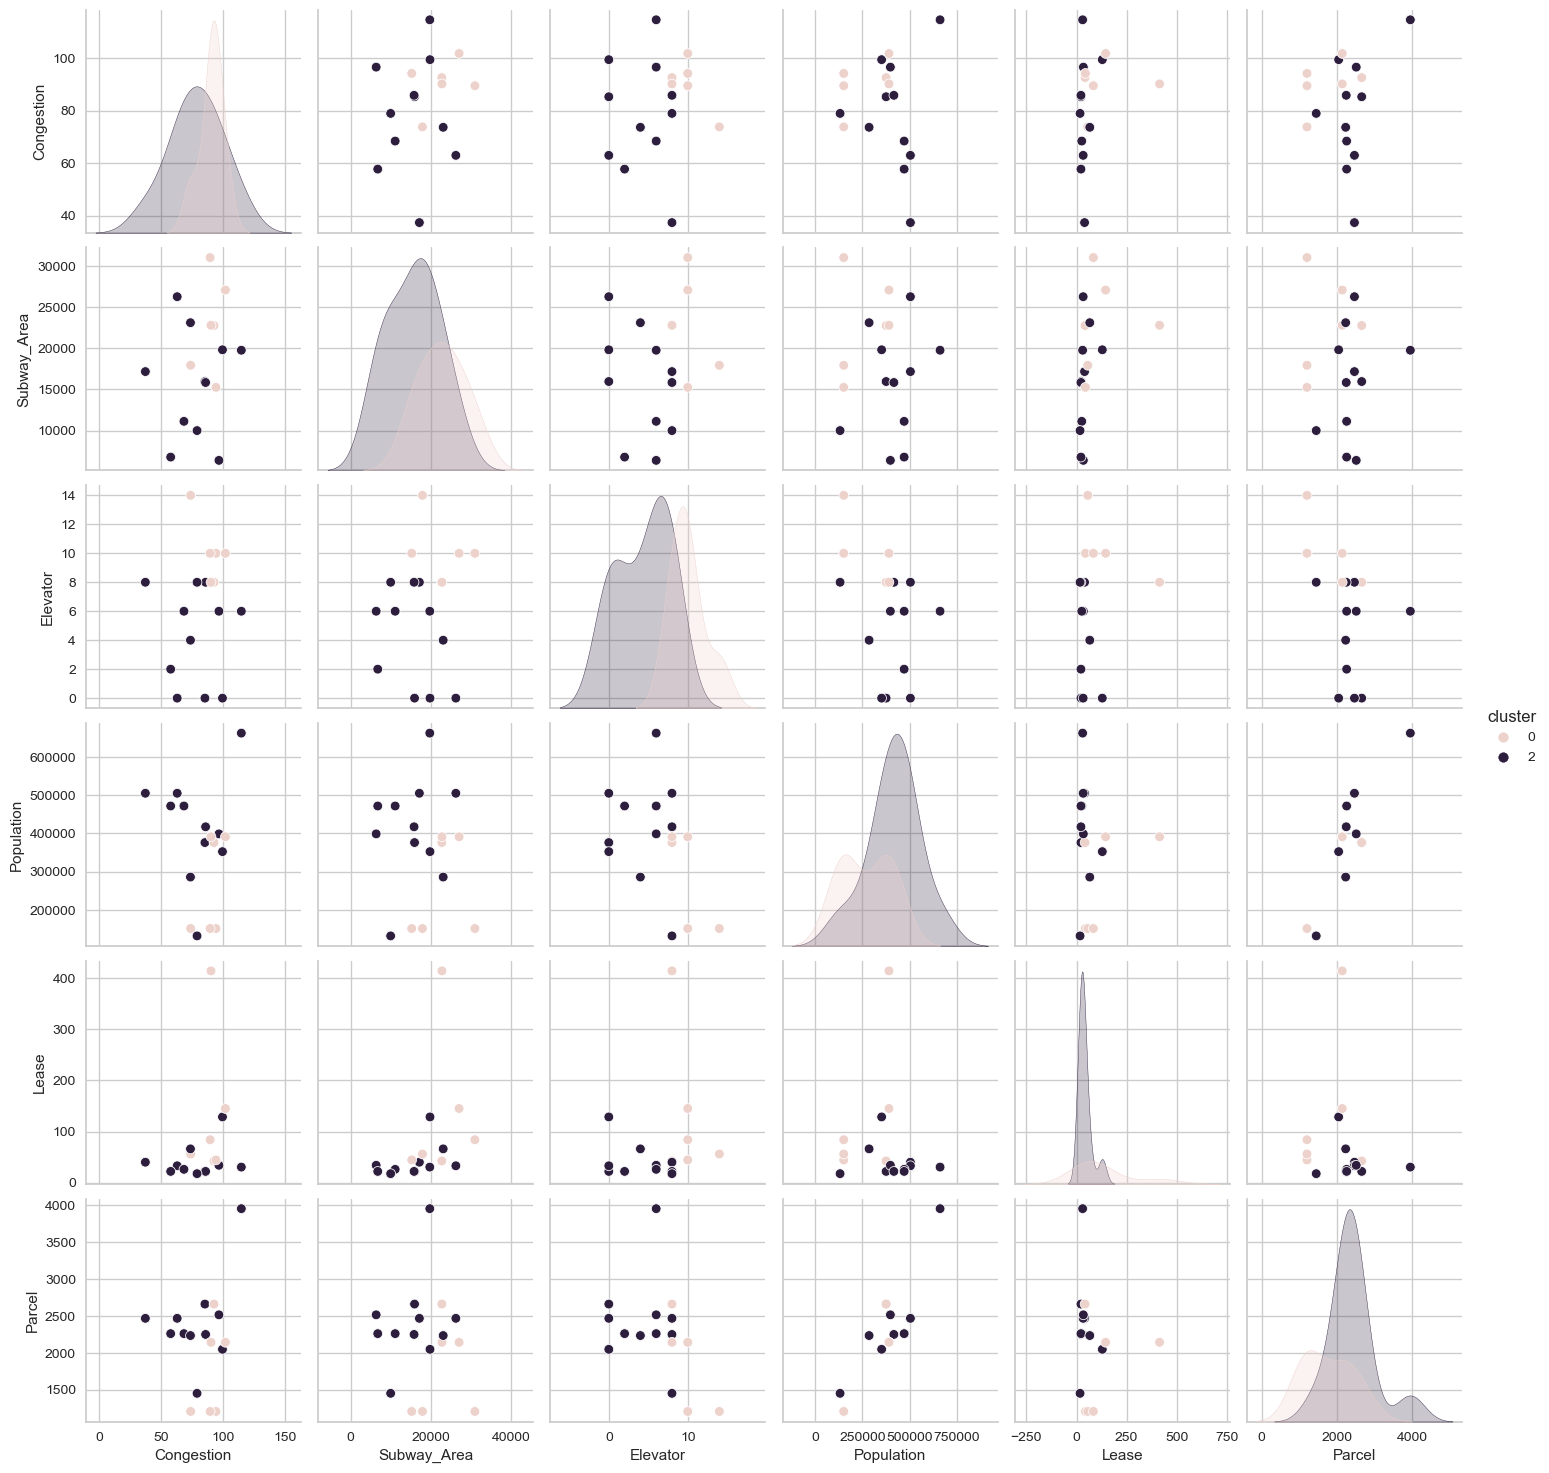

In [35]:
sns.pairplot(Total_SOM, hue="cluster")
plt.show()

### 2. K = 4

### - KMeans

In [36]:
k = 4
KMeans_Model_4 = KMeans(n_clusters = k,init='k-means++', random_state = 1234)

# 정규화된 데이터에 학습
KMeans_Model_4.fit(DS)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
T_KMeans_4 = T_df.copy()
T_KMeans_4['cluster'] = KMeans_Model_4.fit_predict(DS)

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


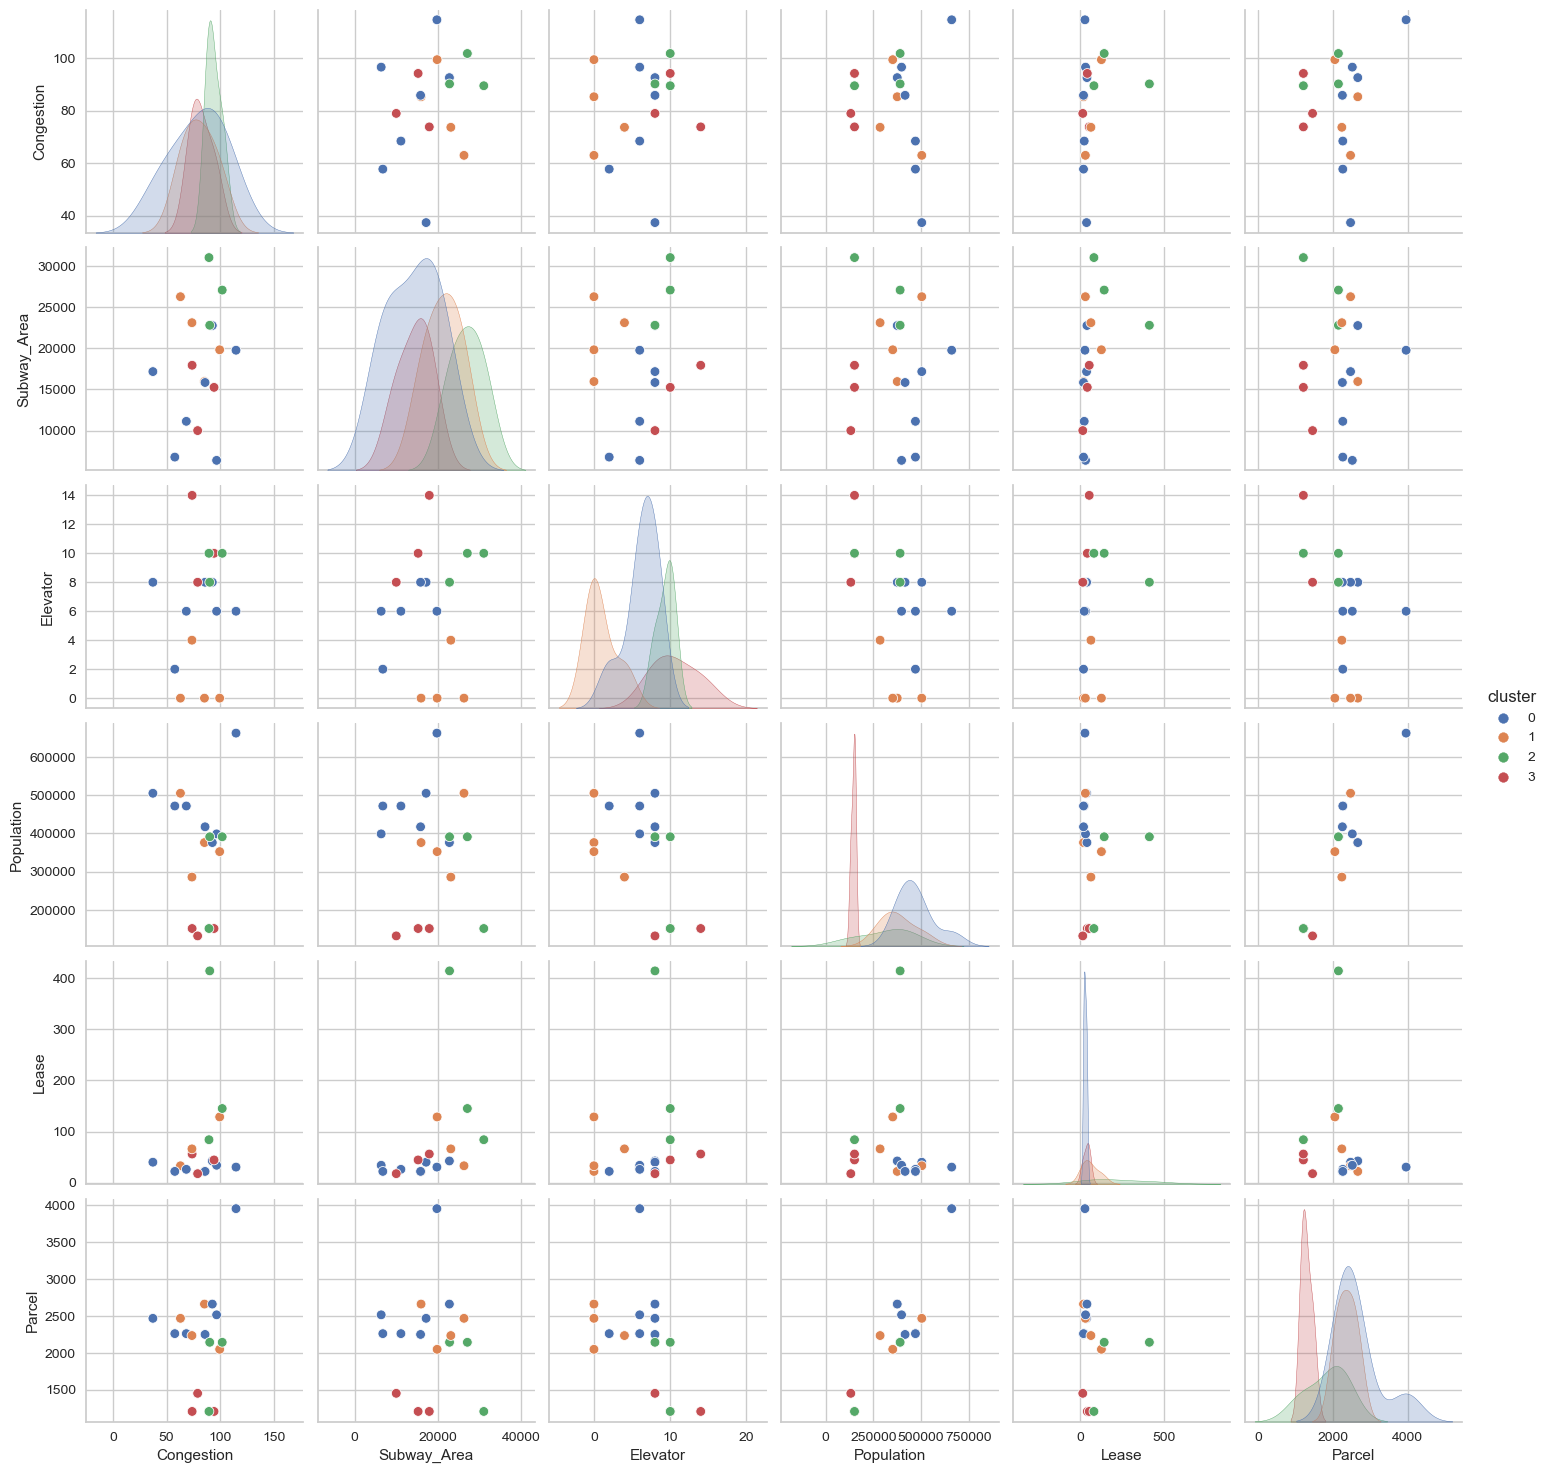

In [59]:
palette = sns.color_palette("deep", 4)
sns.pairplot(T_KMeans_4, hue="cluster", palette = palette)
plt.show()

- 엘리베이터와 역 면적 컬럼을 나타낸 산점도가 가장 군집이 잘 나눠져있음

### - GMM

In [38]:
GMM_4 = GaussianMixture(n_components=4, random_state = 1234)
GMM_4.fit(DS)
cluster = GMM_4.predict(DS)
Total_GMM_4 = T_df.copy()
Total_GMM_4['cluster'] = cluster

C:\Users\Ryzen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


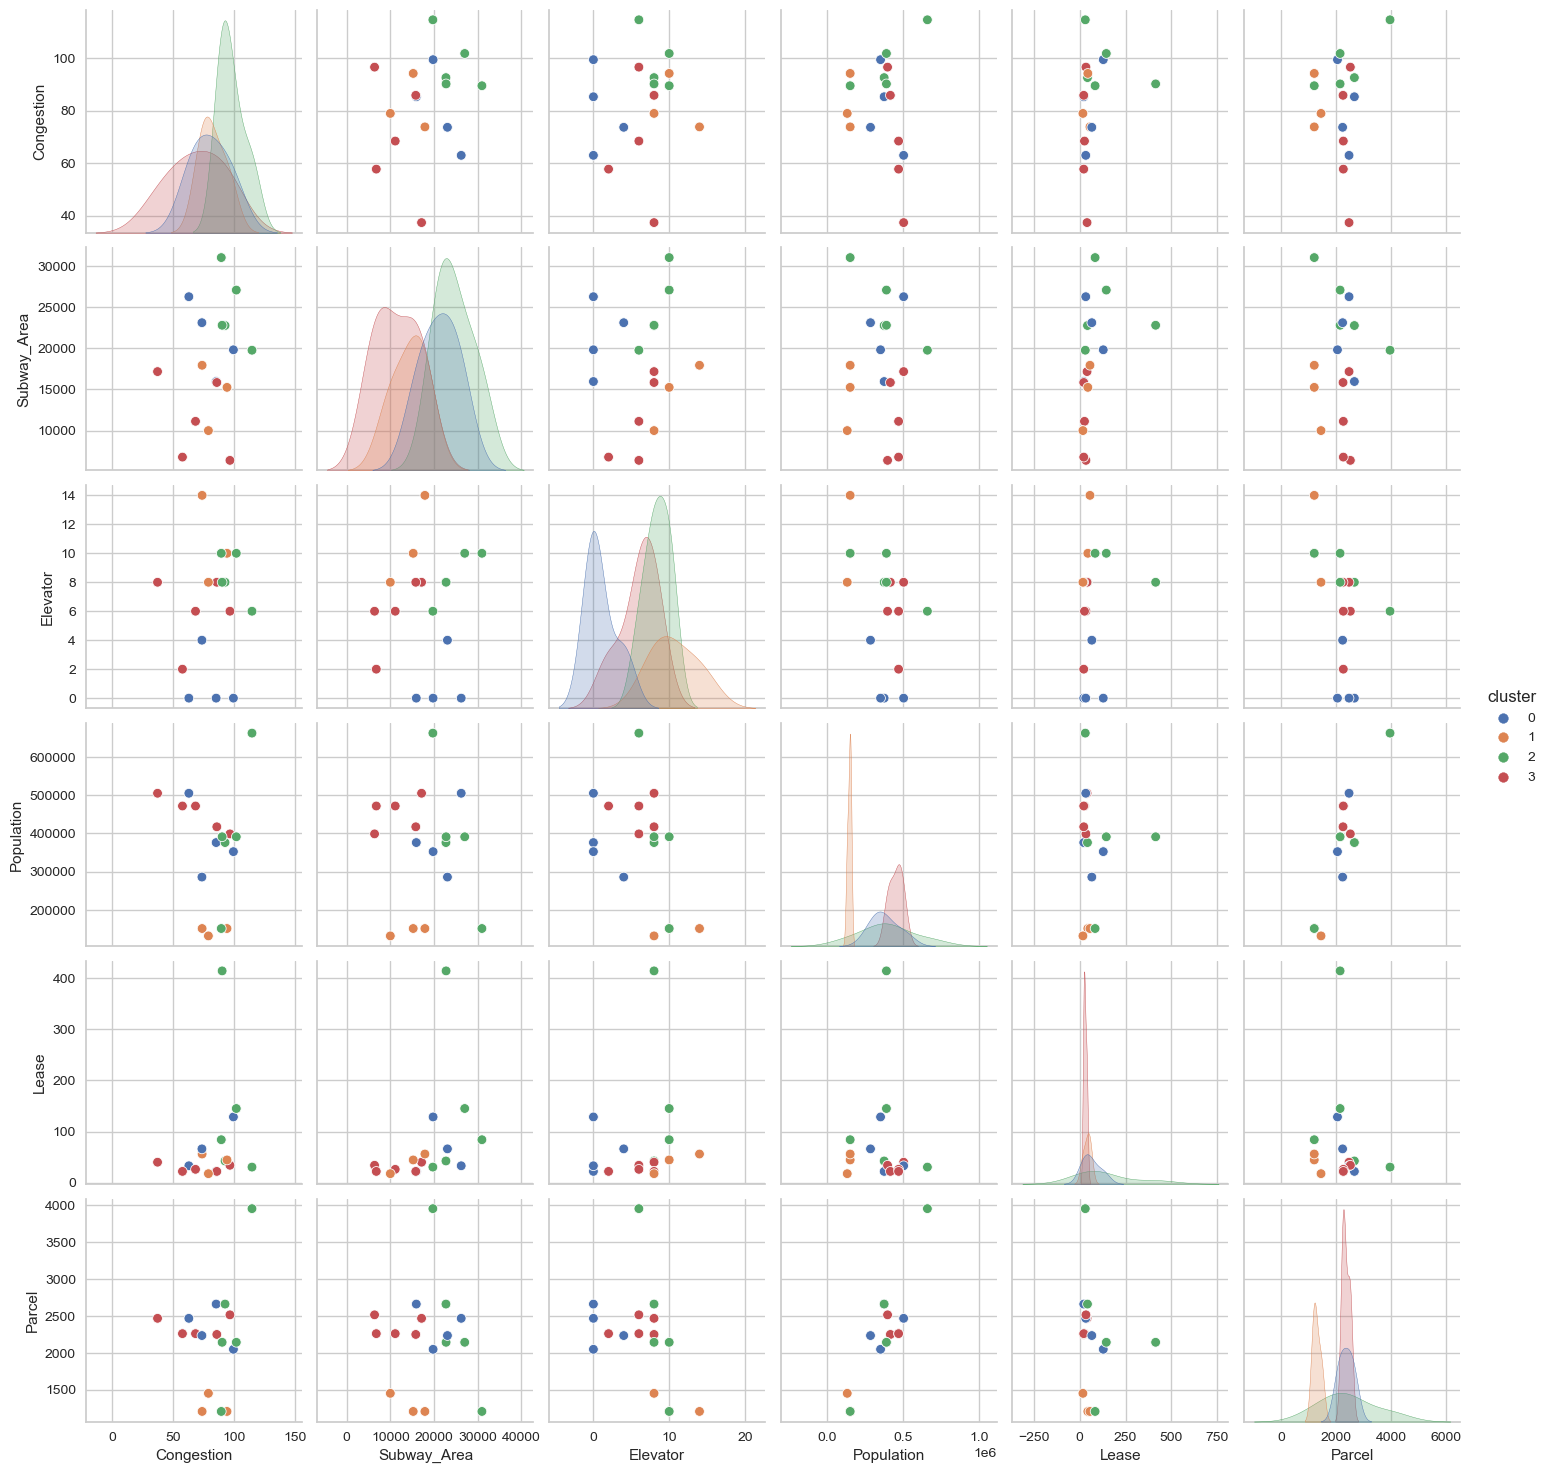

In [62]:
palette = sns.color_palette("deep", 4)
sns.pairplot(Total_GMM_4, hue="cluster", palette = palette)
plt.show()

### - DBSCAN

In [52]:
DBSCAN_Model = DBSCAN(eps=0.4,min_samples=2)
cluster = DBSCAN_Model.fit_predict(DS)
Total_DBSCAN_4 = T_df.copy()
Total_DBSCAN_4['cluster'] = cluster

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


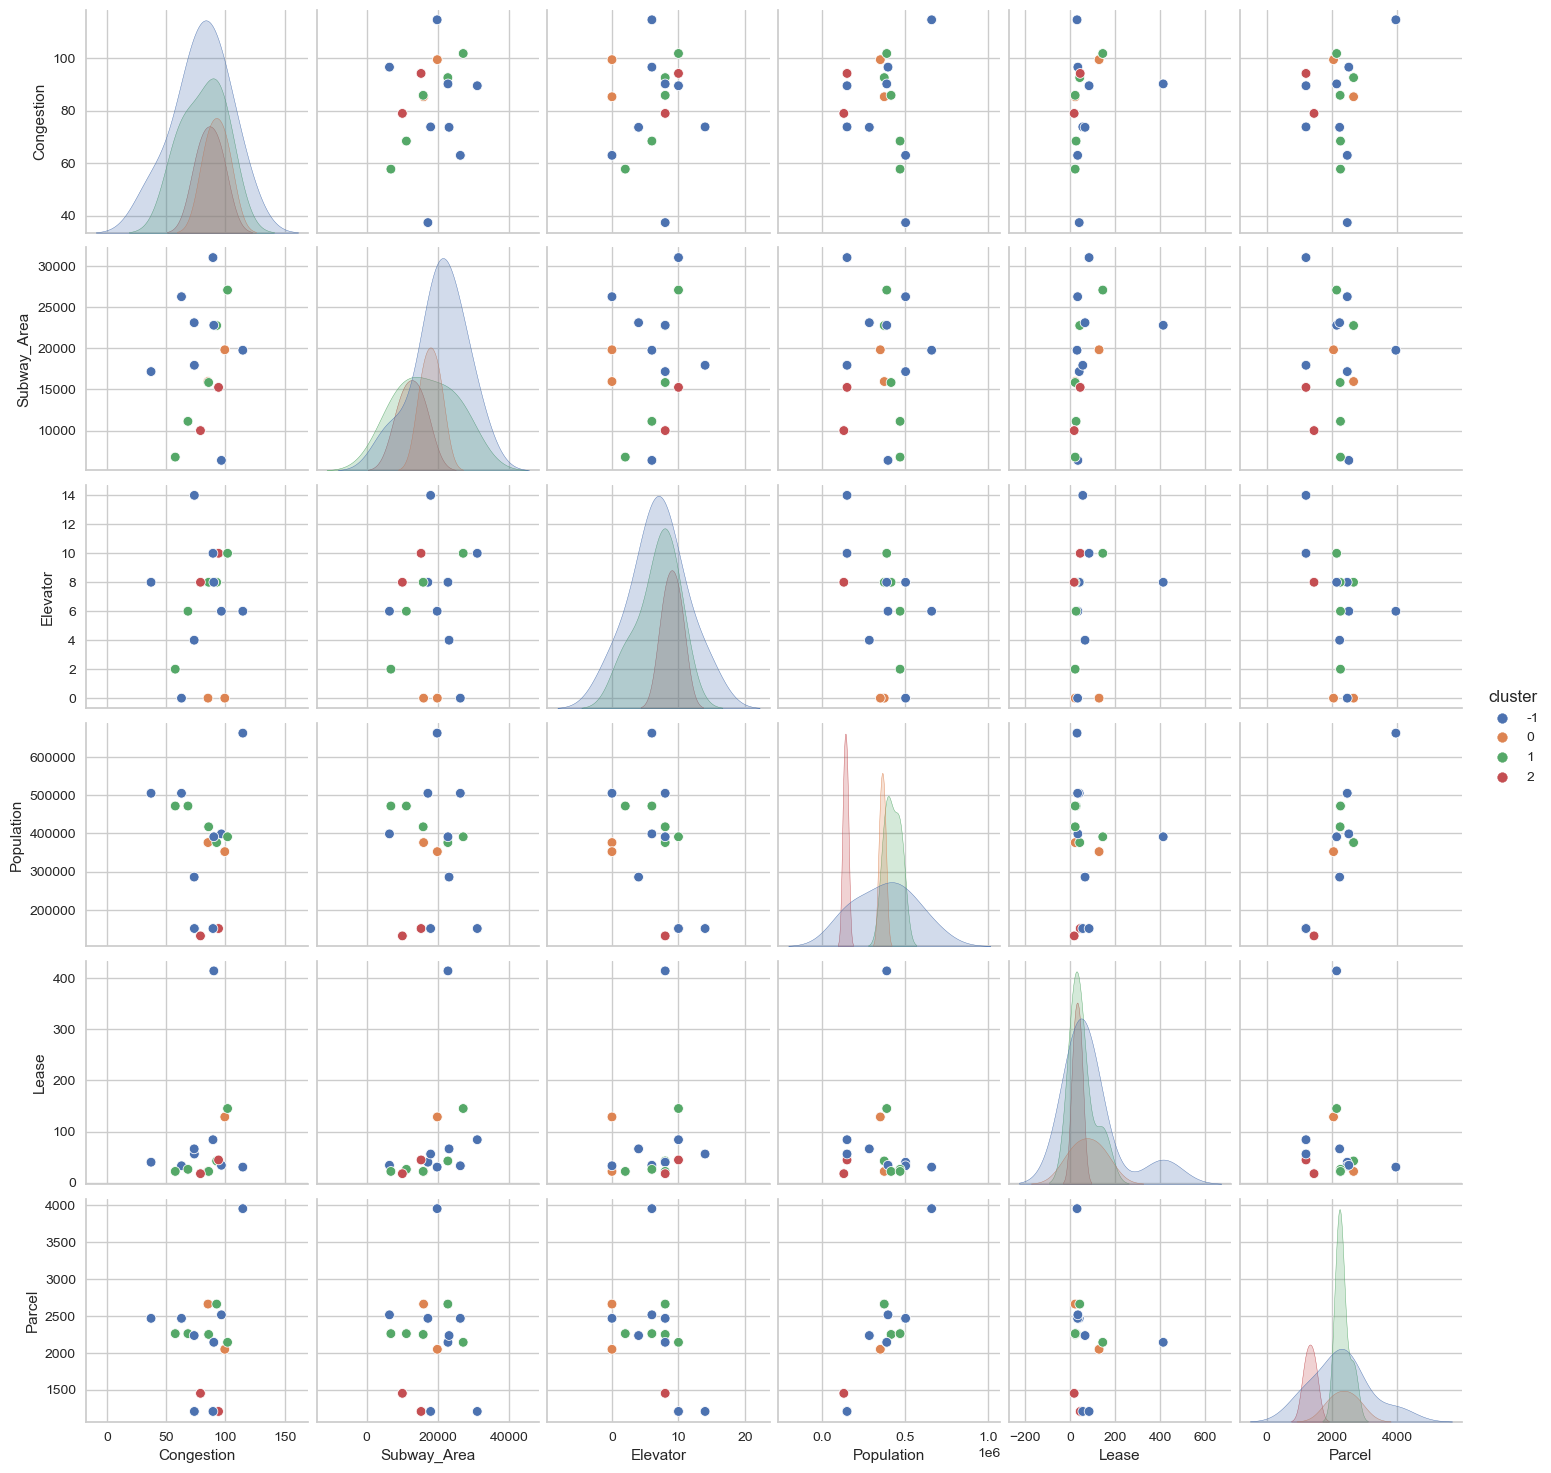

In [60]:
palette = sns.color_palette("deep", 4)
sns.pairplot(Total_DBSCAN_4, hue="cluster", palette = palette)
plt.show()

### - SOM

In [54]:
SOM_4 = MiniSom(x = 2, y = 2, input_len = 5)
SOM_4.random_weights_init(DS.values)
SOM_4.train(DS.values, 100)

In [55]:
Win = np.array([SOM_4.winner(x) for x in DS.values]).T
Total_SOM_4 = T_df.copy()
Total_SOM_4['cluster'] = np.ravel_multi_index(Win,(2,2))

C:\Users\Ryzen\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


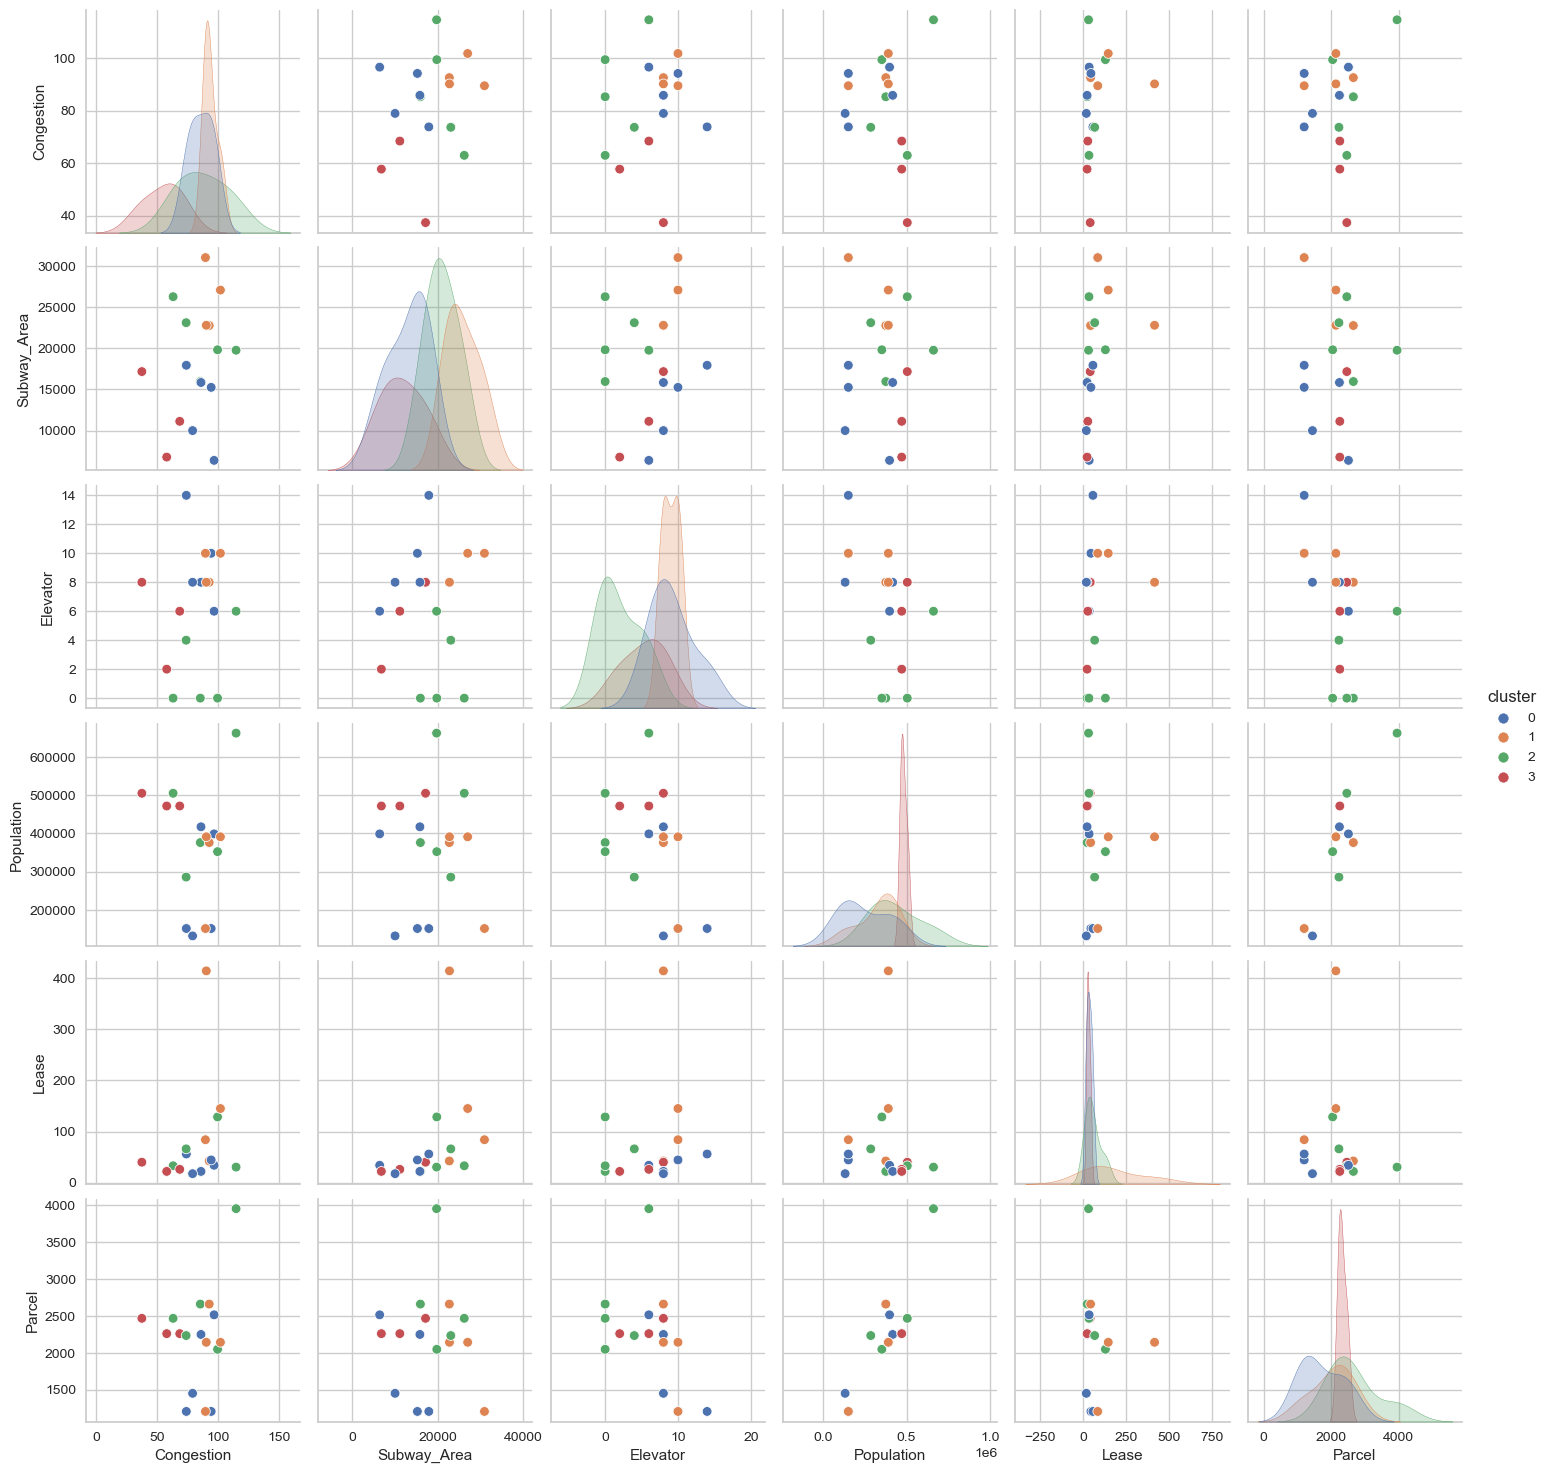

In [61]:
palette = sns.color_palette("deep", 4)
sns.pairplot(Total_SOM_4, hue="cluster", palette = palette)
plt.show()